# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (morfemy). W przeciwieństwie do podejść lingwistycznych, wymagających reguł tworzenia morfemów, BPE wyznacza je automatycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków które występują obok siebie.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20) razy
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10) razy
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technike BPE na tych słowach.

Zaimplementuj algorytm BPE wykonujący `number_of_iterations` iteracji (łączeń symboli).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=0, names=['cluster', 'word', 'count'])

END = 'END'
def preform_bpe(brown_df, number_of_iterations, verbose=False):
    """
    Funckcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    l = df_to_symbols(brown_df.dropna())
    for _ in range(number_of_iterations):
        pair = most_frequent_pair(l)
        if not pair:
            break
        if verbose:
            print(pair)
        l = update_symbols(l, pair)
    
    return [' '.join(w) for w, c in l]
    

def df_to_symbols(brown_df):
    return [
        ([*row['word'], END], row['count'])
        for (i, row)
        in brown_df.iterrows()
    ]

def most_frequent_pair(words):
    counter = Counter()
    for word, count in words:
        for i, sym in enumerate(word[:-2]):
            pair = (sym, word[i+1])
            counter.update({pair: count})
    candidates = counter.most_common(1)
    if candidates:
        return candidates[0][0]

def update_symbols(words, pair):
    a, b = pair
    separate = f"{a} {b}"
    joined = f"{a}{b}"
    for i, (word, count) in enumerate(words):
        word_str = ' '.join(word)
        if separate in word_str:
            word = word_str.replace(separate, joined).split(' ')
            words[i] = (word, count)
    return words

Test implementacji:

In [2]:
from nose.tools import assert_list_equal
data = {'cluster': range(2), 'word':['ala', 'mama'], 'count': [5,10]}
df = pd.DataFrame (data, columns = ['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [3]:
preform_bpe(brown_df, 50, verbose=True);

('i', 'n')
('t', 'h')
('a', 'n')
('e', 'r')
('o', 'n')
('o', 'u')
('r', 'e')
('.', '.')
('a', 't')
('t', 'o')
('in', 'g')
('i', 't')
('th', 'e')
('s', 't')
('<', '@')
('<@', 'M')
('<@M', 'E')
('<@ME', 'N')
('<@MEN', 'T')
('<@MENT', 'I')
('<@MENTI', 'O')
('<@MENTIO', 'N')
('<@MENTION', '>')
('m', 'e')
('o', 'r')
('l', 'l')
('i', 's')
('e', 'n')
('a', 'r')
('l', 'e')
('y', 'ou')
('o', 'w')
('h', 'a')
('c', 'o')
('a', 'y')
('s', 'e')
('<', 'U')
('<U', 'R')
('<UR', 'L')
('<URL', '-')
('v', 'e')
('b', 'e')
('an', 'd')
('l', 'o')
('c', 'h')
('e', 's')
('e', 'd')
('a', 's')
('o', 'f')
('g', 'o')


- Jakie angielskie słowo jako pierwsze dostało swój własny token?

> in

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji (problem OOV, odnieś się do  k-gramów i n-gramów)?

> BPE umożliwia wyciągnięcie przynajmniej części informacji z słów spoza słownika poprzez dopasowanie wspólnych podciągów (potencjalnych morfemów) do znanych wyrazów. Wynika to z faktu, że k-gramy znaków są przestrzenią dużo mniejszą i gęściej wypełnioną od n-gramów słów.

# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [4]:
from helpers import DataSet
training_set = DataSet(['tweets.txt'])

Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [5]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
negative


Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz przykłady uczące na cechy rośnie do bardzo dużych rozmiarów nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [6]:
from collections import Counter
from sklearn.feature_extraction import FeatureHasher
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from helpers import Tweet

def bag_of_words(tweets):
    return [Counter(tweet.tokens) for tweet in tweets]

def tweet_classes(tweets):
    return [tweet.clazz for tweet in tweets]

def train_hashing_svm(bow, classes, n_features=32):
    pipeline = Pipeline([
        ('hasher', FeatureHasher(n_features)),
        ('svm', SVC())
    ])
    pipeline.fit(bow, classes)
    return pipeline

bow = bag_of_words(training_set.tweets)
classes = tweet_classes(training_set.tweets)
train_hashing_svm(bow, classes)

Pipeline(memory=None,
         steps=[('hasher',
                 FeatureHasher(alternate_sign=True,
                               dtype=<class 'numpy.float64'>, input_type='dict',
                               n_features=32)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

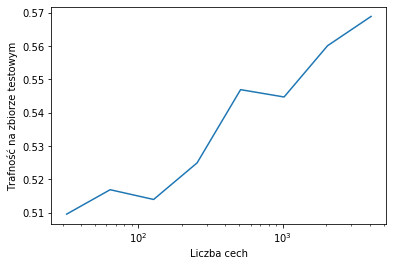

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

size = len(training_set.tweets)
train_size = int(size * 0.75)
train = training_set.tweets[0:train_size]
test = training_set.tweets[train_size+1:]

train_bow = bag_of_words(train)
train_classes = tweet_classes(train)

test_bow = bag_of_words(test)
test_classes = tweet_classes(test)

dims = 2**np.arange(5, 13)
accuracies = []
for d in dims:
    classifier = train_hashing_svm(train_bow, train_classes, d)
    predicted = classifier.predict(test_bow)
    score = accuracy_score(test_classes, predicted)
    accuracies.append(score)

plt.xscale('log')
plt.xlabel('Liczba cech')
plt.ylabel('Trafność na zbiorze testowym')
plt.plot(dims, accuracies)
plt.show()

 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

> Wykres prezentuje zgodny z moimi przewidywaniami trend rosnący. Zmniejszenie liczby cech o połowę pogarsza trafność klasyfikacji o średnio 0,7%.

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [8]:
from sklearn.feature_extraction import DictVectorizer

brown_dict = { row['word']: int(str(row['cluster']), 2) for _, row in brown_df.iterrows() }

def bag_of_clusters(tweets):
    return [
        Counter(brown_dict.get(token, -1) for token in tweet.tokens)
        for tweet in tweets
    ]

def train_brown_svm(boc, classes):
    pipeline = Pipeline([
        ('vectorizer', DictVectorizer()),
        ('svm', SVC())
    ])
    pipeline.fit(boc, classes)
    return pipeline

print('Liczba grup w słowniku:', brown_df['cluster'].nunique())

train_boc = bag_of_clusters(train)
test_boc = bag_of_clusters(test)

classifier = train_brown_svm(train_boc, train_classes)
predicted = classifier.predict(test_boc)
accuracy_score(test_classes, predicted)

Liczba grup w słowniku: 937


0.5879765395894428

- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

> Grupowanie:
> * (-) konieczność zapamiętania, do której grupy należy każde słowo ze słownika,
> * (+) powstałe grupy są łatwiejsze w interpretacji, bo obejmują słowa, które często pojawiały się na podobnych pozycjach w zdaniach.
> * (+) w eksperymencie wyższa trafność klasyfikacji przy mniejszej liczbie grup niż cech haszowanego wektor
>
> Haszowanie:
> * (-) możliwość kolizji, a przez to utraty informacji
> * (+) możliwość doboru liczby cech do własnych potrzeb i możliwości